# Interpretability of Deep Learning: Estimating importance scores
### 1000-719bMSB MIM UW, Neo Christopher Chung


In this lab, we estimate importance scores using backpropagation, creating saliency maps.

In the process, we also learn how to use a pre-trained model, called SqueezeNet (AlexNet-level accuracy with 50x fewer parameters and 0.5MB model size), which can be loaded directly from PyTorch.  
https://arxiv.org/abs/1602.07360
https://en.wikipedia.org/wiki/SqueezeNet

We further look at the ImageNet which is one of the most popular and important database consisted of milliions of images across 20000 categories. For Colab, we use only a small portion of the ImageNet 
https://ieeexplore.ieee.org/document/5206848
https://en.wikipedia.org/wiki/ImageNet

Using these ingredients, we calculate backpropgagtion based importance scores from scratch.

Please be mindful of both original (multi-channel) values and summaried 2D values. Both are used widely in practice.

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

from matplotlib import cm
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

from google.colab import drive
drive.mount('/content/gdrive')

#sample ImageNet data from https://github.com/CNN-ADF/Task2020
!wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/imagenet_val_25.npz' -q

<ipython-input-28-1faa2546458a>:7: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [ ]:
def load_imagenet_val(num=None):
    f = np.load('imagenet_val_25.npz', allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    idx = np.arange(25)
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
        X   = X[idx]
        y   = y[idx]
    return X, y, class_names
    
#X, y, class_names = load_imagenet_val(num=5)

In [ ]:
#Load and use all 25 images from a smaller set, downloaded
f = np.load('imagenet_val_25.npz', allow_pickle=True)
X = f['X']
y = f['y']
class_names = f['label_map'].item()
print(X.shape)
print(y.shape)

(25, 224, 224, 3)
(25,)


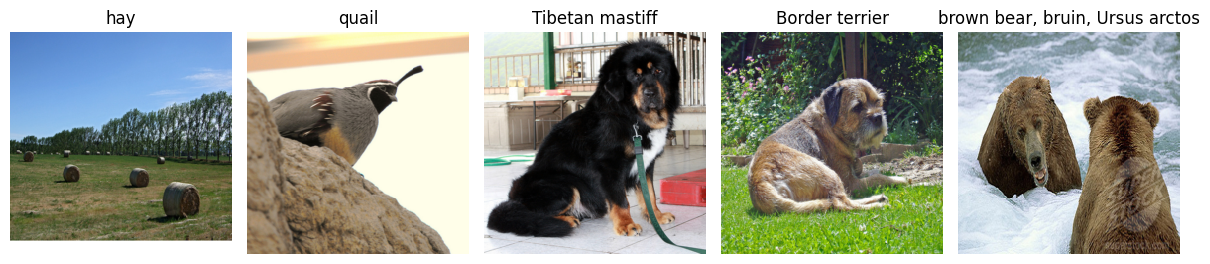

In [ ]:
# show some images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [ ]:
# Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016
model = torchvision.models.squeezenet1_1(pretrained=True)
#print(model)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 50.9MB/s]


In [ ]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)
model.eval()
scores = model(X_tensor)
print(scores)
scores_y = scores.gather(1, y_tensor.view(-1, 1)).squeeze()
print(scores_y)

tensor([[ 9.0406,  1.1808,  3.4227,  ...,  4.6864,  8.0145,  5.2129],
        [ 5.9101,  4.6083,  6.9259,  ...,  9.7415,  9.6305,  9.3974],
        [ 1.6097,  4.0396,  4.4560,  ...,  3.4892, 11.6411, 12.5561],
        ...,
        [ 5.5077,  3.8930,  3.3218,  ...,  4.5410,  7.9065, 15.4184],
        [ 7.6427,  8.8772,  4.0593,  ...,  9.6345,  7.5668, 10.8771],
        [ 8.6750, 13.4218, 11.4606,  ...,  6.1399,  5.2605, 10.4970]])
tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723, 25.4353, 15.6568, 34.9214,
        22.9094, 13.7762, 18.1419, 10.5448, 23.5066, 46.3714, 39.0091, 27.1299,
        25.8614, 19.7288, 18.6807, 20.9641, 25.2686, 18.7046, 21.7245, 12.6422,
        15.0523])


In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    model.eval()
    X.requires_grad_()
    
    # 1. Forward pass
    scores = model(X)
    
    # 2. Get correct class scores
    scores = scores.gather(1, y.view(-1, 1)).squeeze()

    # 3. Backward pass
    scores_size = scores.shape
    ones_tensor = torch.ones(scores_size)
    scores.backward(ones_tensor)

    # 4. retrieve the gradient as saliency map
    saliency = X.grad
    return saliency

def compute_abs(saliency):
    saliency_abs = saliency.abs()
    return saliency_abs

def compute_max(saliency):
    saliency_max, _= torch.max(saliency, dim=1)
    return saliency_max 

In [ ]:
## calculating gradients for CORRECT labels
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

# Compute saliency maps for images in X
saliency = compute_saliency_maps(X_tensor, y_tensor, model)

# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
saliency = saliency.numpy()
print(saliency.shape)

(25, 3, 224, 224)


In [ ]:
print(saliency[10,0,:,:])
print(saliency[10,:,:,:].shape)

[[ 2.4181213e-04  3.9806162e-04  5.4919685e-04 ...  6.5556014e-05
  -3.4736539e-04  0.0000000e+00]
 [ 2.9708163e-04  2.7688337e-04  2.1230827e-04 ...  1.5718871e-04
  -2.9223145e-04  0.0000000e+00]
 [-2.4404669e-04 -4.7465481e-05 -7.3008396e-04 ... -1.4069052e-04
  -8.6801668e-04  0.0000000e+00]
 ...
 [-2.0839507e-03 -1.3333262e-03 -1.5112874e-04 ... -4.7466398e-04
   4.2720439e-04  0.0000000e+00]
 [-2.7535877e-03 -2.1331632e-03 -1.3772733e-04 ...  9.6664520e-04
   1.3330282e-03  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
(3, 224, 224)


(-0.25, 0.25)

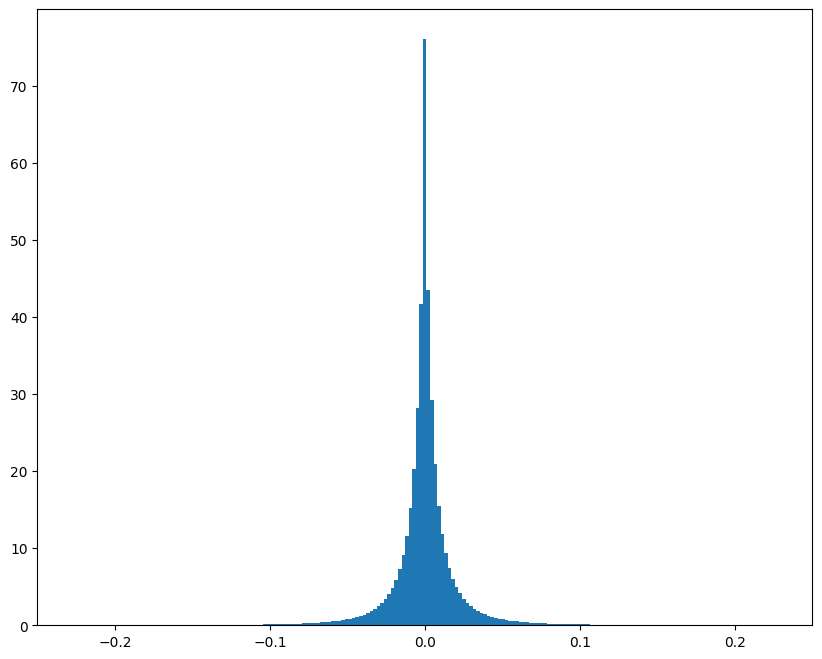

In [ ]:
# look at the historgram of the saliency maps
plt.hist(saliency.flatten(), density=True, bins=1000)
plt.xlim([-0.25,0.25])

### Lab Exericse
Plot the saliency maps (as captured in a variable, `saliency') for the available imagenet samples.

First, plot each channel of saliency maps (e.g., without further summarization)

Second, compute the maximum of absolute values from multi-channel saliency maps, and then plot the resulting 2D saliency maps.

